In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tarfile
import urllib.request
import os
from pathlib import Path
import re
from helpers.dataset_explore import display_model_image, display_model_fragments, display_fragment_image, display_fragment_and_model
from helpers.zookeeper import index_zoo_files, parse_zoo_filename, match_models_to_zoo_files
from helpers.parsers import parse_yuml_model,  inspect_model_yuml_visually
from helpers.stats import compute_model_stats, compute_dataset_summary, pretty_print_summary
from helpers.graphs import print_inheritance_hierarchy, draw_inheritance_graph
import networkx as nx

### **Dataset Download** (If not present) and path setting

In [2]:
# Automatically set working dir to the notebook location
base_dir = os.path.dirname(os.path.abspath("__file__")) 
print(base_dir)
os.chdir(base_dir)

# Dataset details
url = "https://github.com/songyang-dev/uml-classes-and-specs/releases/download/v1.0.0/dataset.tar.gz"
tar_path = "dataset.tar.gz"
extract_dir = "dataset"

# Download dataset if not already present
if not os.path.exists(tar_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, tar_path)
    print("Download complete.")
else:
    print("Dataset archive already exists. Skipping download.")

# Extract dataset if not already extracted (in 'dataset')
if not os.path.isdir(extract_dir):
    print("Extracting dataset into folder 'dataset/'...")
    os.makedirs(extract_dir, exist_ok=True)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)  # Extract inside 'dataset'
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Count total number of files extracted
file_count = sum(len(files) for _, _, files in os.walk(extract_dir))
print(f"{file_count} files found in '{extract_dir}'.")

zoo_dir = Path(extract_dir) / "zoo"

/Users/piachouaifaty/GitHub/Siemens___Task/uml-classes-and-specs
Download complete.
Extracting dataset into folder 'dataset/'...
Extraction complete.
25877 files found in 'dataset'.


### Logic

**Acyclic Directed Inheritance Graphs** based on model.yuml

**Depth**: inheritance depth

In UML:

        NamedElement
           ▲
     ┌─────┼─────┐
     DataBase Table Column
 
DataBase inherits from NamedElement

Table inherits from NamedElement

Column inherits from NamedElement

The arrow points to the parent. The child is the source, the parent is the target

### Preprocessing

In [3]:
#creates a dataframe of all files in zoo for matching
zoo_idx = index_zoo_files()

In [4]:
#read in dataset files
dataset_path = Path(extract_dir)

fragments = pd.read_csv(dataset_path / "fragments.csv")
labels = pd.read_csv(dataset_path / "labels.csv")
models = pd.read_csv(dataset_path / "models.csv")

In [5]:
matched_df, unmatched_files_df, unmatched_models_df = match_models_to_zoo_files(models, zoo_idx)
#matched_df contains all zoo files matched to their corresponding models

unmatched_models_df (models without matching file_: None. 

unmatched_files_df: zoo files with no corresponding model: mostly metadata

In [6]:
parsed_cols = matched_df["file_name"].apply(lambda fn: pd.Series(parse_zoo_filename(fn), index=["kind", "number", "file_type"]))
#parse_zoo_filename: extracts kind, number, and file type from zoo filename. resulting df joined to matched_df

matched_df = pd.concat([matched_df, parsed_cols], axis=1)

# extract all full model yuml files to use downstream
yuml_df = matched_df[
    (matched_df["file_type"] == "yuml") &
    (matched_df["kind"] == "full")
].copy()

In [7]:
#coverage sanity check

covered_models = set(yuml_df["model"])
all_models = set(models["name"])

missing_models = all_models - covered_models

print(f"Models with .yuml: {len(covered_models)}")
print(f"Models missing .yuml: {len(missing_models)}")

if missing_models:
    print("Missing model examples:", list(missing_models))

Models with .yuml: 280
Models missing .yuml: 0


### Parsing Model .yuml

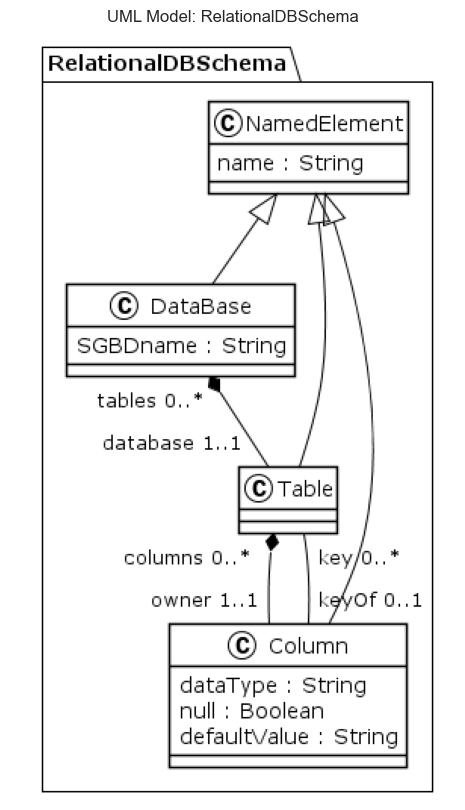

In [8]:
display_model_image("RelationalDBSchema")
#helper function to quickly display UML png from model name

Inspecting .yuml: dataset/zoo/Java-20040316.yuml

Classes (9): ['ClassFeature', 'ClassMember', 'FeatureParameter', 'Field', 'JavaClass', 'JavaElement', 'Method', 'Package', 'PrimitiveType']
Inheritance Edges (8): [('ClassFeature', 'JavaElement'), ('ClassMember', 'ClassFeature'), ('Field', 'ClassMember'), ('JavaClass', 'ClassFeature'), ('Method', 'ClassMember'), ('Package', 'JavaElement'), ('PrimitiveType', 'JavaClass'), ('FeatureParameter', 'ClassFeature')]
Associations (5): [('ClassMember', 'JavaClass', 'aggregation'), ('JavaClass', 'ClassMember', 'composition'), ('JavaClass', 'FeatureParameter', 'aggregation'), ('Method', 'FeatureParameter', 'composition'), ('Package', 'JavaClass', 'composition')]

Inheritance Hierarchy:

Building inheritance graph...
Original edges (child --> parent):
  ClassFeature → JavaElement
  ClassMember → ClassFeature
  Field → ClassMember
  JavaClass → ClassFeature
  Method → ClassMember
  Package → JavaElement
  PrimitiveType → JavaClass
  FeatureParameter 

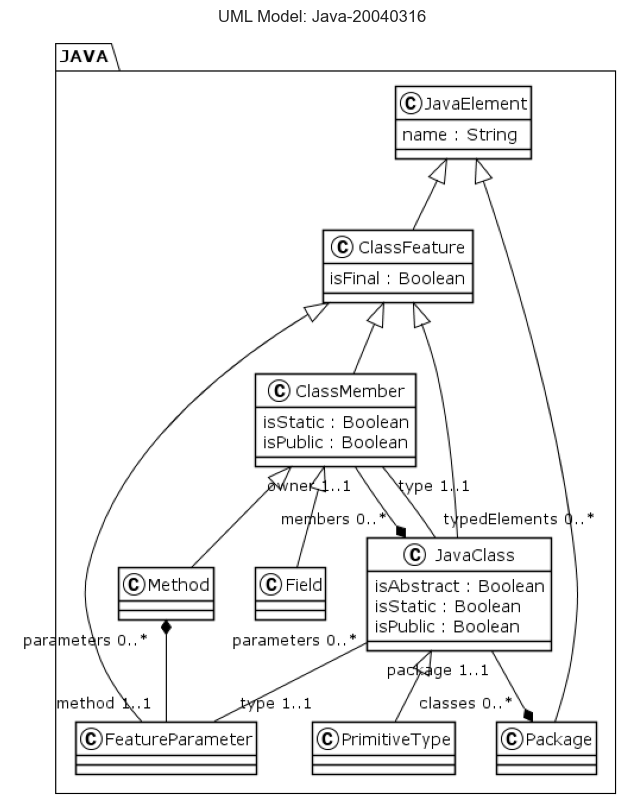


Inheritance Hierarchy:


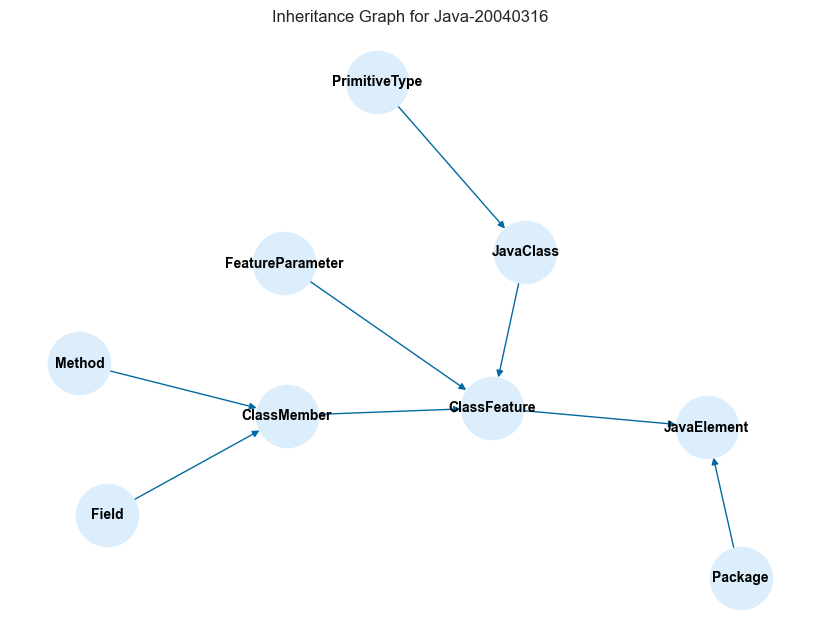

In [9]:
inspect_model_yuml_visually("Java-20040316", yuml_df)
#helper function, inspects .yuml, extracts hierarchy, prints graph inheritance graph traversal
#displays original UML diagram
#draws inheritance graph

### Statistics

Compute Stats for All Models

(individual usage: compute_model_stats("model name", yuml_df))

**yuml_df could be abstracted better / hidden in the preprocessing as an improvement

In [10]:
models = yuml_df["model"].unique()

all_stats = []
for model_name in models:
    try:
        stats = compute_model_stats(model_name, yuml_df)
        all_stats.append(stats)
    except ValueError as e:
        print(f"[WARNING] Skipping {model_name}: {e}")

stats_df = pd.DataFrame(all_stats)
stats_df

,model,num_classes,num_inheritance,num_associations,association_types,num_blocks,tree_depth,most_frequent_label
0,ACG,71,71,39,"{'composition': 37, 'unknown': 2}",181,4,inheritance
1,ACME,16,12,10,{'composition': 10},38,2,inheritance
2,ADELFE,19,9,12,"{'composition': 6, 'unknown': 3, 'aggregation'...",40,1,inheritance
3,ASM,37,35,44,"{'composition': 42, 'aggregation': 1, 'unknown...",116,3,composition
4,ATL,84,83,69,"{'composition': 62, 'aggregation': 5, 'unknown...",236,5,inheritance
...,...,...,...,...,...,...,...,...
275,sbvrEclipse,332,195,344,"{'aggregation': 38, 'unknown': 305, 'compositi...",871,8,unknown
276,sbvrOMG,193,195,66,"{'aggregation': 38, 'unknown': 27, 'compositio...",454,8,inheritance
277,useCase,8,3,7,"{'composition': 3, 'aggregation': 2, 'unknown'...",18,1,composition
278,vb,67,65,74,"{'composition': 71, 'unknown': 3}",206,5,composition


In [11]:
#outputs statistics for all models
stats_df.to_csv("uml_model_statistics.csv", index=False)

In [12]:
summary = compute_dataset_summary(stats_df)
pretty_print_summary(summary)


UML Dataset Summary
Total models: 280
Total blocks: 25031
  - Classes: 9384
  - Inheritance edges: 7643
  - Associations: 8004

Depth Statistics
----------------------------------------
Average tree depth: 2.34
Standard deviation: 1.79
Maximum tree depth: 10
  - Models with max depth: Marte
Minimum tree depth: 0
  - Models with min depth: Architectural_Description, Automaton, Book, CPR, MTRANS, ODP-IV, ODP-TV, PDG, Parameters, Person, Problem, Publication, RSS-2.0, SeminarSchedulingSystem, SimpleAirlineDomain, Table, Trace, UDDI_meta-model_fragment, WTIP_SimpleRDBMS, WfMC, CompanyStructure, ComponentUML, Contact, DTMP, DXF, EclipsePlugIn, Family, FlatSignalFlow, GWPNV0, GWPNV1, GWPNV2, Gantt, GeoTrans, HybridAutomata, IMSTransactionMessage

Blocks per Model
----------------------------------------
Average: 89.4
Standard deviation: 189.99

Classes per Model
----------------------------------------
Average: 33.51
Standard deviation: 72.06

Relationship Label Distribution
---------------